# Convolutional neural networks (CNNs)

State-of-the-art image classification is performed with [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs) that use [convolution layers](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/) to extract features from images and [pooling layers](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/) to downsize images so features can be detected at various resolutions. Let's use Keras to build a CNN and train it to differentiate between photos containing hot dogs, pizza, and sushi. Note that CNNs perform best when trained with thousands (or tens or hundreds of thousands) of images. In this example, you will use 60 images for training and 30 for testing.

![](Images/cnn.png)

## Create an image pipeline

The first step is to use Keras's [ImageDataGenerator](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) class to create a pipeline for loading images. While the number of images used here is relatively small, one of the benefits of using `ImageDataGenerator` is that it allows you train a CNN with more images than can fit into memory at one time. We will create two image pipelines: one for training images and one for test images. Because `class_mode` is set to `categorical`, labels will be inferred from directory names ("hotdog," "pizza," and "sushi").

In [1]:
from keras.preprocessing.image import ImageDataGenerator

image_batch_size = 10
idg = ImageDataGenerator(rescale=1./255)

train_generator = idg.flow_from_directory(
    directory='food/train',
    target_size=(224, 224),
    batch_size=image_batch_size,
    class_mode='categorical',
    seed=42
)

test_generator = idg.flow_from_directory(
    directory='food/test',
    target_size=(224, 224),
    batch_size=image_batch_size,
    class_mode='categorical',
    seed=42
)

Found 60 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


use `ImageDataGenerator`'s `class_indices` property to show classes and labels.

In [2]:
class_indices = train_generator.class_indices
print(class_indices)

{'hotdog': 0, 'pizza': 1, 'sushi': 2}


Define a function for converting a one-hot-encoded class value into the corresponding label.

In [3]:
def get_label(y, indices):
    return list(indices.keys())[list(indices.values()).index(y.argmax(axis=-1))]

In order to visualize the data, use Matplotlib to plot the first eight training images.

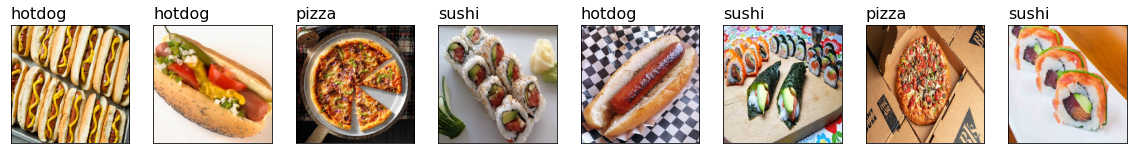

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

images = train_generator[0][0] # First 10 images
labels = train_generator[0][1] # First 10 labels

fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.text(0.0, 1.05, get_label(labels[i], class_indices), transform=ax.transAxes, fontsize=16)
    
train_generator.reset()

Now do the same for the first eight test images.

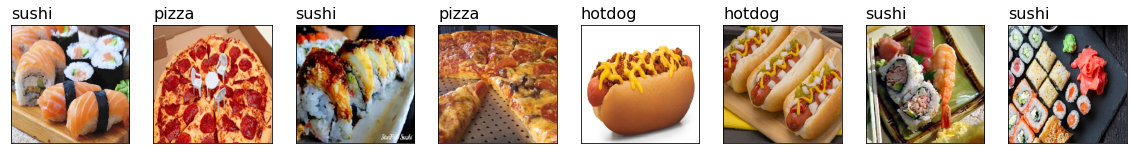

In [5]:
images = test_generator[0][0] # First 10 images
labels = test_generator[0][1] # First 10 labels

fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.text(0.0, 1.05, get_label(labels[i], class_indices), transform=ax.transAxes, fontsize=16)
    
test_generator.reset()

## Build and train a CNN

Keras makes it easy to build and train CNNs using classes such as [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/#conv2d-class) and [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/#maxpooling2d-class). Let's build a CNN with three convolutional layers, followed by a pair of fully connected layers for classification. We will use a dropout of 20% to help the CNN generalize better.

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 128)     36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

Train the model by calling `fit` and inputting the `train_generator`.

In [7]:
hist = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // image_batch_size,
    validation_data=test_generator,
    validation_steps= test_generator.samples // image_batch_size,
    batch_size=5,
    epochs=20
)

Epoch 1/20
6/6 [==============================] - 2s 300ms/step - loss: 1.3207 - accuracy: 0.2833 - val_loss: 1.0757 - val_accuracy: 0.3333
Epoch 2/20
6/6 [==============================] - 2s 263ms/step - loss: 1.0873 - accuracy: 0.4167 - val_loss: 1.0428 - val_accuracy: 0.3333
Epoch 3/20
6/6 [==============================] - 2s 266ms/step - loss: 0.9905 - accuracy: 0.4667 - val_loss: 1.0403 - val_accuracy: 0.4667
Epoch 4/20
6/6 [==============================] - 2s 262ms/step - loss: 0.8972 - accuracy: 0.6167 - val_loss: 1.0478 - val_accuracy: 0.3667
Epoch 5/20
6/6 [==============================] - 2s 263ms/step - loss: 0.7680 - accuracy: 0.6333 - val_loss: 0.7171 - val_accuracy: 0.7000
Epoch 6/20
6/6 [==============================] - 2s 266ms/step - loss: 0.5162 - accuracy: 0.7833 - val_loss: 0.5813 - val_accuracy: 0.8000
Epoch 7/20
6/6 [==============================] - 2s 266ms/step - loss: 0.3131 - accuracy: 0.8833 - val_loss: 0.9119 - val_accuracy: 0.6333
Epoch 8/20
6/6 [====

How well did the CNN train? Let's plot the training accuracy and validation accuracy for each epoch.

[]

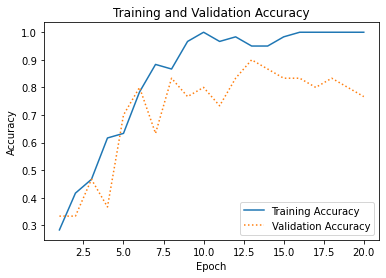

In [8]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

The validation accuracy is decent, but it's not state-of-the art. Modern CNNs often achieve an accuracy of 95% or more doing image classification. You could increase the accuracy by deepening the network and increasing the number of training images by an order of magnitude or more, but training time would increase commensurately. One solution for that is to do the training on an HPC cluster outfitted with GPUs. A more practical solution is [transfer learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a), which enables sophisticated image-classification networks to be trained on an ordinary CPU.